### Import Libraries and Test Images

In [13]:
# standard imports
from typing import Dict, List
import numpy as np
import xarray as xr
import pandas as pd
import rioxarray
import matplotlib.pyplot as plt

# load up the saved dataset
import pickle
with open('/Users/Adrian/Documents/VS CODE/spicy-snow/tests/test_data/2_img_ds', 'rb') as f:
    ds = pickle.load(f)

# add module to path so python can import it. This is the directory with 
# the __init__.py file in it to let python know this is a module.
import sys
sys.path.append('/Users/Adrian/Documents/VS CODE/spicy-snow/spicy_snow')

# import the function to test
from processing.s1_preprocessing import s1_amp_to_dB, s1_dB_to_amp, merge_partial_s1_images

#dataset = ds.isel(time = slice(1, 3))
dataset = ds

In [2]:
dataset

<xarray.Dataset>
Dimensions:         (x: 292, y: 292, band: 3, time: 3)
Coordinates:
  * x               (x) float64 -114.1 -114.1 -114.1 ... -114.0 -114.0 -114.0
  * y               (y) float64 43.1 43.1 43.1 43.1 43.1 ... 43.0 43.0 43.0 43.0
  * band            (band) <U3 'VV' 'VH' 'inc'
    spatial_ref     int64 0
  * time            (time) datetime64[ns] 2019-02-25T01:27:19 ... 2019-03-21T...
    flight_dir      (time) <U9 'ascending' 'ascending' 'ascending'
    platform        (time) <U3 'S1B' 'S1B' 'S1B'
    relative_orbit  (time) int64 20 20 20
    projection      int64 0
Data variables:
    s1              (time, band, y, x) float32 0.1726 0.158 ... 0.6242 0.6236
    ims             (time, y, x) int8 4 4 4 4 4 4 4 4 4 4 ... 2 2 2 2 2 2 2 2 2
    fcf             (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

### Plot Incidence Angles Before Mask

(array([2.92000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.80000e+01,
        1.10900e+03, 5.92980e+04, 1.87979e+05, 6.90800e+03, 1.88000e+02]),
 array([ 0.        ,  4.85425186,  9.70850372, 14.56275558, 19.41700745,
        24.27125931, 29.12551117, 33.97976303, 38.83401489, 43.68826675,
        48.54251862]),
 <BarContainer object of 10 artists>)

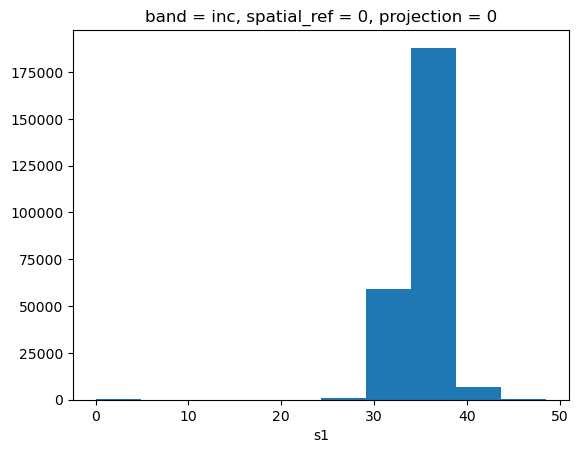

In [15]:
# BEFORE

#s1_inc = s1[0, 2]
#s1_inc >= 0.7
#s1[dict(time=0, band=2)]

s1 = dataset.s1
s1_inc = s1.drop_sel(band=['VV', 'VH'])
s1_inc_deg = s1_inc * 180/(np.pi)
#s1_inc.isel(time=0).plot()
s1_inc_deg.plot()

### Test Masking Function

In [8]:
# Select incidence angle from s1 data array
for band in ['inc']:
    data = dataset['s1'].sel(band=band)
    # Convert radians to degrees
    data_deg = data * 180/(np.pi)

    # Mask pixels with incidence angle > 70 degrees ('inc' <= 0.7)
    #data_masked = data.where(data <= 1.22)
    data_masked = data_deg.where(data <= 0.7)

    dataset['s1'].loc[dict(band = band)] = data_masked

### Plot Incidence Angles After Mask

(array([2.9200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3000e+01, 4.8400e+02, 1.1809e+04, 1.7888e+05, 6.1594e+04]),
 array([ 0.        ,  4.01053572,  8.02107143, 12.03160763, 16.04214287,
        20.05267906, 24.06321526, 28.07375145, 32.08428574, 36.09482193,
        40.10535812]),
 <BarContainer object of 10 artists>)

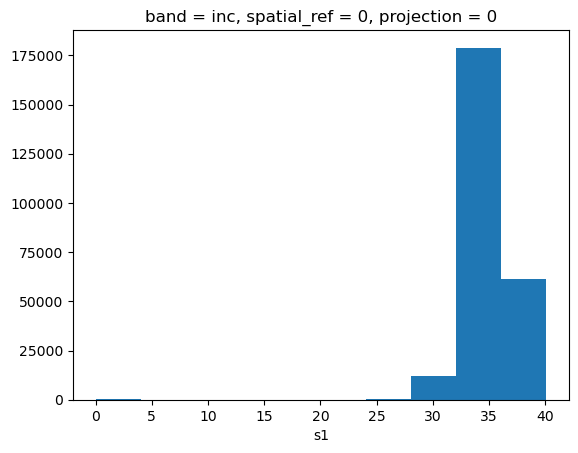

In [10]:
# AFTER
s1_after = dataset.s1
s1_afterinc = s1.drop_sel(band=['VV', 'VH'])
#s1_afterinc.isel(time=0).plot()
s1_afterinc.plot()

## FINAL FUNCTION

In [ ]:
def s1_incidence_angle_masking(dataset: xr.Dataset, inplace: bool = False) -> xr.Dataset:
"""
Remove s1 image outliers by masking pixels with incidence angles > 70 degrees

Args:
dataset: Xarray Dataset of sentinel images to mask incidence angle outliers

Returns:
dataset: Xarray Dataset of sentinel images with incidence angles > 70 degrees
masked
"""
 
# Check inplace flag
if not inplace:
        dataset = dataset.copy(deep=True)


# Mask pixels with incidence angle > 70 degrees
for band in ['inc']:
        data = dataset['s1'].sel(band=band)
        # Convert 'inc' from radians to degrees
        data_deg = data * 180/(np.pi)

        # Mask array ('inc' <= 0.7)
        dataset['s1'].loc[dict(band = band)] = data_deg.where(data_deg <= 0.7)

if not inplace:
        return dataset